# Log

자료 리스트의 4번째 데이터까지 학습!
* 약 800명 데이터 



# Regression
---

* Data: STL images
* Backbone: Inception ResNet v2

In [1]:
import csv
import glob
import os
import pprint
from tqdm import tqdm

from IPython import display
import ipywidgets as widgets

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('seaborn-white')
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')

import cv2 as cv

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras import models, layers, activations, initializers, regularizers, optimizers, losses, callbacks
from tensorflow.keras import backend as K
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

## Paths
---

In [2]:
input_path_root = r'H:/projects/clear_aligner/'

output_path_root = r'F:/workspace/projects/clear_aligner/2020/dentis_ai/results/'
output_path = os.path.join(output_path_root, r'reg_so_img_inception_resnet_v2_2020-12-14/base')
output_path_weight = os.path.join(output_path, r'weights/')

try:
    os.makedirs(output_path_weight)
except FileExistsError as err:
    print(err)
else:
    print(output_path)
    print(output_path_weight)

[WinError 183] 파일이 이미 있으므로 만들 수 없습니다: 'F:/workspace/projects/clear_aligner/2020/dentis_ai/results/reg_so_img_inception_resnet_v2_2020-12-14/base\\weights/'


## Data
---

In [3]:
def convert_label_class2reg(label_df):
    label_r = np.copy(label_df.angle_class_r)
    label_df.loc[label_r == 1, 'angle_class_r'] = 0
    label_df.loc[label_r == 2, 'angle_class_r'] = 1
    label_df.loc[label_r == 3, 'angle_class_r'] = -1
    
    label_l = np.copy(label_df.angle_class_l)
    label_df.loc[label_l == 1, 'angle_class_l'] = 0
    label_df.loc[label_l == 2, 'angle_class_l'] = 1
    label_df.loc[label_l == 3, 'angle_class_l'] = -1
    
    return label_df

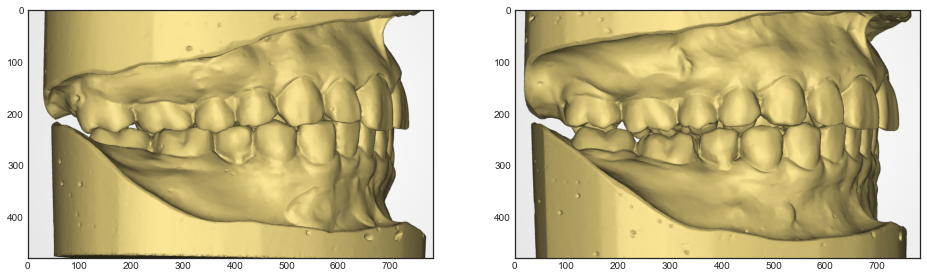

float32 (2282, 480, 784, 3)
float32 (2282,)

float32 (978, 480, 784, 3)
float32 (978,)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1630 entries, 0 to 1629
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   patient_id     1630 non-null   object
 1   tx             1630 non-null   int64 
 2   tx_phase       1630 non-null   object
 3   angle_class_r  1630 non-null   int64 
 4   angle_class_l  1630 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 63.8+ KB


None

,patient_id,tx,tx_phase,angle_class_r,angle_class_l
0,QH0026,1,Pre-Tx,0,0
1,QH0026,1,Post-Tx,0,1
2,QH0041,1,Pre-Tx,1,0
3,QH0041,1,Post-Tx,1,0
4,QH0044,1,Pre-Tx,1,1
...,...,...,...,...,...
1625,QH1353,1,Post-Tx,0,0
1626,QH1354,1,Pre-Tx,-1,-1
1627,QH1354,1,Post-Tx,0,1
1628,QH1355,1,Pre-Tx,1,1


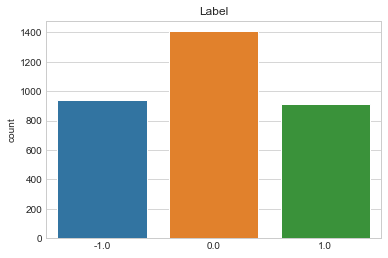

In [4]:
# Read datasets.
x = np.load(os.path.join(input_path_root, f'data_KNU_Diorco_so_imgs_01-04.npy'))
label_df = pd.read_csv(os.path.join(input_path_root, f'data_KNU_Diorco_so_img_labels_01-04.csv'))

label_df_class = label_df.copy()
y_class = label_df_class.loc[:, ['angle_class_r', 'angle_class_l']].to_numpy()

label_df = convert_label_class2reg(label_df)
y = label_df.loc[:, ['angle_class_r', 'angle_class_l']].to_numpy()

x = x.astype(np.float32)
y = y.astype(np.float32)

# Normalization
x = x / 127.5
x = x - 1.

# Split the dataset.
n_val_data = len(x) // 10 * 3
x_train = x[n_val_data:]
y_train = y[n_val_data:]
y_class_train = y_class[n_val_data:]
label_df_train = label_df.iloc[n_val_data:]
label_df_class_train = label_df_class.iloc[n_val_data:]

x_val = x[:n_val_data]
y_val = y[:n_val_data]
y_class_val = y_class[:n_val_data]
label_df_val = label_df.iloc[:n_val_data]
label_df_class_val = label_df_class.iloc[:n_val_data]

# Split lateral view images (left and right).
x_train = np.concatenate([x_train[..., :3], x_train[..., 3:]])
y_train = np.concatenate([y_train[:, 0], y_train[:, 1]])
y_class_train = np.concatenate([y_class_train[:, 0], y_class_train[:, 1]])
x_val = np.concatenate([x_val[..., :3], x_val[..., 3:]])
y_val = np.concatenate([y_val[:, 0], y_val[:, 1]])
y_class_val = np.concatenate([y_class_val[:, 0], y_class_val[:, 1]])

plt.figure(figsize=(16, 8))

plt.subplot(121)
plt.imshow((x_train[0] + 1) / 2)

plt.subplot(122)
plt.imshow((x_train[len(x_train) // 2] + 1) / 2)

plt.show()

print(x_train.dtype, x_train.shape)
print(y_train.dtype, y_train.shape)
print()
print(x_val.dtype, x_val.shape)
print(y_val.dtype, y_val.shape)
print()
display.display(label_df.info())
display.display(label_df)

with plt.style.context('seaborn-whitegrid'):
    plt.figure()

    plt.title('Label')
    sns.countplot(x=y.ravel())

    plt.show()

## Model
---

In [5]:
def build_model():
    base_model = InceptionResNetV2(include_top=False, weights=None, input_shape=(None, None, 3))

    x = base_model.output

    x = layers.GlobalAveragePooling2D(name='gap')(x)
    x = layers.Dense(256, activation='relu', name='dense')(x)
    x = layers.Dropout(0.2, name='dropout')(x)
    output_main = layers.Dense(1, name='output_main')(x)

    model = models.Model(inputs=base_model.input, outputs=output_main)
    
    return model

In [9]:
%env PYTHONHASHSEED=0
from random import seed as random_seed
random_seed(42)
from numpy.random import seed as np_random_seed
np_random_seed(42)

model = build_model()

model.compile(optimizer=optimizers.Adam(1e-3),
              loss=losses.MeanSquaredError(),
              metrics=['mae'])

model.save(os.path.join(output_path, r'model.hdf5'))

# model.summary()

## Train the Model
---

In [ ]:
checkpointer = callbacks.ModelCheckpoint(os.path.join(output_path_weight, 'weights_{epoch:08d}_{val_loss:.3e}.hdf5'),
                                         save_weights_only=True)
csv_logger = callbacks.CSVLogger(os.path.join(output_path, r'log.csv'), append=True)

model.fit(x_train, y_train,
          validation_data=(x_val, y_val),
          batch_size=16,
          initial_epoch=0,
          epochs=200,
          callbacks=[checkpointer, csv_logger])

## Evaluation
---

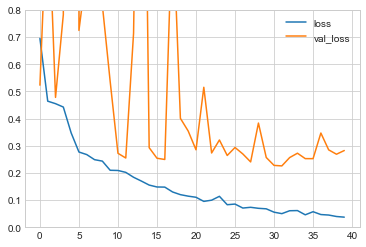

31


In [22]:
log_df = pd.read_csv(os.path.join(output_path, r'log.csv'))

with plt.style.context('seaborn-whitegrid'):
    plt.figure()

    plt.plot(log_df.loss, label='loss')
    plt.plot(log_df.val_loss, label='val_loss')
    plt.ylim(0, 0.8)
    plt.legend()

    plt.show()
    print(log_df.val_loss.idxmin())

In [23]:
K.clear_session()

model = models.load_model(os.path.join(output_path, r'model.hdf5'))
model.load_weights(glob.glob(os.path.join(output_path_weight, f'weights_{32:08d}*.hdf5'))[0])

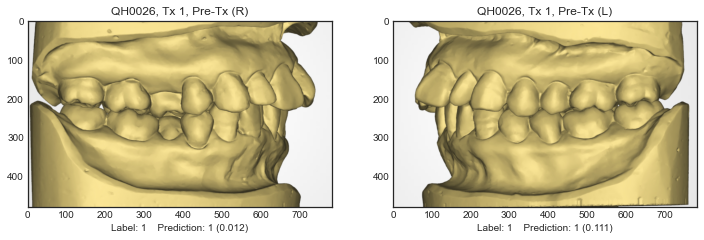

In [74]:
predictions_prob = model.predict(x_val)

predictions = np.round(predictions_prob)
predictions[predictions_prob < -1] = -1
predictions[predictions_prob > 1] = 1

predictions_class = predictions.copy()
predictions_class[predictions == 0] = 1
predictions_class[predictions == 1] = 2
predictions_class[predictions == -1] = 3
predictions_class = predictions_class.astype(np.uint8)

plt.figure(figsize=(12, 6))

plt.subplot(121)
data_idx1 = 0
title = ', '.join([label_df_val.iloc[data_idx1, 0], 'Tx ' + str(label_df_val.iloc[data_idx1, 1]), label_df_val.iloc[data_idx1, 2]])
plt.title(f'{title} (R)')
plt.imshow((x_val[data_idx1] + 1) / 2)
plt.xlabel(f'Label: {y_class_val[data_idx1]}    Prediction: {predictions_class[data_idx1, 0]} ({predictions_prob[data_idx1, 0]:.3f})')

plt.subplot(122)
data_idx2 = data_idx1 + len(x_val) // 2
plt.title(f'{title} (L)')
plt.imshow((np.fliplr(x_val[data_idx2]) + 1) / 2)
plt.xlabel(f'Label: {y_class_val[data_idx2]}    Prediction: {predictions_class[data_idx2, 0]} ({predictions_prob[data_idx2, 0]:.3f})')

plt.show()
print('', end='\n\n')

In [75]:
cm = confusion_matrix(y_class_val, predictions_class, labels=[1, 2, 3])

print(cm)

[[397  35  36]
 [ 47 192   0]
 [103  11 157]]


### Accuracy

In [76]:
accuracy = (cm[0, 0] + cm[1, 1] + cm[2, 2]) / cm.sum()

print(f'Accuracy: {accuracy:.3f}')

Accuracy: 0.763


### Recall

In [77]:
recall_class1 = cm[0, 0] / cm[0].sum()
recall_class2 = cm[1, 1] / cm[1].sum()
recall_class3 = cm[2, 2] / cm[2].sum()
recall = (recall_class1 + recall_class2 + recall_class3) / 3

print(f'Class 1: {recall_class1:.3f}')
print(f'Class 2: {recall_class2:.3f}')
print(f'Class 3: {recall_class3:.3f}')
print(f'Recall (average): {recall:.3f}')

Class 1: 0.848
Class 2: 0.803
Class 3: 0.579
Recall (average): 0.744


### Precision

In [78]:
precision_class1 = cm[0, 0] / cm[:, 0].sum()
precision_class2 = cm[1, 1] / cm[:, 1].sum()
precision_class3 = cm[2, 2] / cm[:, 2].sum()
precision = (precision_class1 + precision_class2 + precision_class3) / 3

print(f'Class 1: {precision_class1:.3f}')
print(f'Class 2: {precision_class2:.3f}')
print(f'Class 3: {precision_class3:.3f}')
print(f'Precision (average): {precision:.3f}')

Class 1: 0.726
Class 2: 0.807
Class 3: 0.813
Precision (average): 0.782


## Write the Results
---

In [95]:
len_half_predictions = len(predictions_class) // 2

label_df_class_val.insert(2, 'angle_class_r_prediction', predictions_class.squeeze()[:len_half_predictions])
label_df_class_val.insert(3, 'angle_class_r_prediction_prob', predictions_prob.squeeze()[:len_half_predictions])
label_df_class_val.loc['angle_class_r_prediction_prob'] = label_df_class_val.angle_class_r_prediction_prob.round(2)
label_df_class_val.insert(4, 'angle_class_r_T/F', label_df_class_val.angle_class_r == label_df_class_val.angle_class_r_prediction)

label_df_class_val.insert(6, 'angle_class_l_prediction', predictions_class.squeeze()[len_half_predictions:])
label_df_class_val.insert(7, 'angle_class_l_prediction_prob', predictions_prob.squeeze()[len_half_predictions:])
label_df_class_val.loc['angle_class_l_prediction_prob'] = label_df_class_val.angle_class_l_prediction_prob.round(2)
label_df_class_val.insert(8, 'angle_class_l_T/F', label_df_class_val.angle_class_l == label_df_class_val.angle_class_l_prediction)

label_df_class_val

,patient_id,tx,angle_class_r_prediction,angle_class_r_prediction_prob,angle_class_r_T/F,tx_phase,angle_class_l_prediction,angle_class_l_prediction_prob,angle_class_l_T/F,angle_class_r,angle_class_l
0,QH0026,1,1,0.01,True,Pre-Tx,1,0.11,True,1,1
1,QH0026,1,1,0.12,True,Post-Tx,2,0.99,True,1,2
2,QH0041,1,1,0.05,False,Pre-Tx,2,0.52,False,2,1
3,QH0041,1,2,0.99,True,Post-Tx,1,0.04,True,2,1
4,QH0044,1,2,0.92,True,Pre-Tx,2,0.99,True,2,2
...,...,...,...,...,...,...,...,...,...,...,...
484,QH0980,1,1,-0.00,True,Pre-Tx,1,0.37,True,1,1
485,QH0980,1,3,-0.69,True,Post-Tx,1,-0.00,False,3,3
486,QH0983,1,1,0.01,True,Pre-Tx,3,-1.01,True,1,3
487,QH0983,1,1,0.03,True,Post-Tx,1,0.00,True,1,1


In [94]:
output_path_result = os.path.join(output_path, 'results.csv')
label_df_class_val.to_csv(output_path_result, index=False)

with open(output_path_result, 'a', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow([])
    writer.writerow([None, None, None, 'Predicted Class'])
    writer.writerow([None, None, None, 1, 2, 3])
    writer.writerow([None, 'Actual Class', 1] + cm[0].tolist())
    writer.writerow([None, None, 2] + cm[1].tolist())
    writer.writerow([None, None, 3] + cm[2].tolist())
    writer.writerow([])
    writer.writerow([None, None, 'Class 1', 'Class 2', 'Class 3', 'Average'])
    writer.writerow([None, 'Accuracy', None, None, None, accuracy])
    writer.writerow([None, 'Recall', recall_class1, recall_class2, recall_class3, recall])
    writer.writerow([None, 'Precision', precision_class1, precision_class2, precision_class3, precision])